<a href="https://www.kaggle.com/code/juanpablocordon/asl-proyecto?scriptVersionId=270103148" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/asl-fingerspelling/supplemental_metadata.csv
/kaggle/input/asl-fingerspelling/character_to_prediction_index.json
/kaggle/input/asl-fingerspelling/train.csv
/kaggle/input/asl-fingerspelling/supplemental_landmarks/371169664.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/369584223.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1682915129.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/775880548.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2100073719.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1650637630.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/1471096258.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/86446671.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/897287709.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/333606065.parquet
/kaggle/input/asl-fingerspelling/supplemental_landmarks/2057261717.parquet
/kaggle/inpu

In [2]:
pip install mediapipe

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import shutil
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import tensorflow as tf
import json
import mediapipe
import matplotlib
import matplotlib.pyplot as plt
import random

from skimage.transform import resize
from mediapipe.framework.formats import landmark_pb2
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm
from matplotlib import animation, rc

2025-10-22 18:36:21.159661: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761158181.182242     278 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761158181.189022     278 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
dataset_df = pd.read_csv('/kaggle/input/asl-fingerspelling/train.csv')
print("Full train dataset shape is {}".format(dataset_df.shape))

Full train dataset shape is (67208, 5)


In [5]:
# Fetch sequence_id, file_id, phrase from first row
sequence_id, file_id, phrase = dataset_df.iloc[21][['sequence_id', 'file_id', 'phrase']]
print(f"sequence_id: {sequence_id}, file_id: {file_id}, phrase: {phrase}")

sequence_id: 1817606833, file_id: 5414471, phrase: 6867 granville drive


In [6]:
# Fetch data from parquet file
sample_sequence_df = pq.read_table(f"/kaggle/input/asl-fingerspelling/train_landmarks/{str(file_id)}.parquet",
    filters=[[('sequence_id', '=', sequence_id)],]).to_pandas()
print("Full sequence dataset shape is {}".format(sample_sequence_df.shape))

Full sequence dataset shape is (182, 1630)


In [7]:
sample_sequence_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pan

,frame,x_face_0,x_face_1,x_face_2,x_face_3,x_face_4,x_face_5,x_face_6,x_face_7,x_face_8,...,z_right_hand_11,z_right_hand_12,z_right_hand_13,z_right_hand_14,z_right_hand_15,z_right_hand_16,z_right_hand_17,z_right_hand_18,z_right_hand_19,z_right_hand_20
sequence_id,,,,,,,,,,,,,,,,,,,,,
1817606833,0,0.570902,0.558401,0.562891,0.548021,0.557151,0.557396,0.559568,0.480127,0.558788,...,-0.223153,-0.230523,-0.160219,-0.21842,-0.212521,-0.203194,-0.174814,-0.213587,-0.205547,-0.195536
1817606833,1,0.569334,0.556892,0.561190,0.546795,0.555722,0.556057,0.558490,0.479120,0.558037,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1817606833,2,0.568485,0.557382,0.561676,0.547050,0.556201,0.556424,0.558390,0.479365,0.557564,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1817606833,3,0.567084,0.556220,0.560351,0.545671,0.555038,0.555174,0.556935,0.478996,0.556084,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1817606833,4,0.566671,0.553219,0.557732,0.543397,0.552064,0.552495,0.555219,0.478589,0.554772,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
dataset_df.columns

Index(['path', 'file_id', 'sequence_id', 'participant_id', 'phrase'], dtype='object')

In [9]:
# Function create animation from images.
import matplotlib

matplotlib.rcParams['animation.embed_limit'] = 2**128
matplotlib.rcParams['savefig.pad_inches'] = 0
rc('animation', html='jshtml')

def create_animation(images):
    fig = plt.figure(figsize=(6, 9))
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    im=ax.imshow(images[0], cmap="gray")
    plt.close(fig)
    
    def animate_func(i):
        im.set_array(images[i])
        return [im]

    return animation.FuncAnimation(fig, animate_func, frames=len(images), interval=1000/10)

In [10]:
# 10 Extraer los datos y convertirlos en una imagen usando medipipe.
# Esta función extrae datos para ambas manos.

mp_pose = mediapipe.solutions.pose
mp_hands = mediapipe.solutions.hands
mp_drawing = mediapipe.solutions.drawing_utils 
mp_drawing_styles = mediapipe.solutions.drawing_styles

def get_hands(seq_df):
    images = []
    all_hand_landmarks = []
    for seq_idx in range(len(seq_df)):
        x_hand = seq_df.iloc[seq_idx].filter(regex="x_right_hand.*").values
        y_hand = seq_df.iloc[seq_idx].filter(regex="y_right_hand.*").values
        z_hand = seq_df.iloc[seq_idx].filter(regex="z_right_hand.*").values

        right_hand_image = np.zeros((600, 600, 3))

        right_hand_landmarks = landmark_pb2.NormalizedLandmarkList()

        for x, y, z in zip(x_hand, y_hand, z_hand):
            right_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
                right_hand_image,
                right_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        x_hand = seq_df.iloc[seq_idx].filter(regex="x_left_hand.*").values
        y_hand = seq_df.iloc[seq_idx].filter(regex="y_left_hand.*").values
        z_hand = seq_df.iloc[seq_idx].filter(regex="z_left_hand.*").values
        
        left_hand_image = np.zeros((600, 600, 3))
        
        left_hand_landmarks = landmark_pb2.NormalizedLandmarkList()
        for x, y, z in zip(x_hand, y_hand, z_hand):
            left_hand_landmarks.landmark.add(x=x, y=y, z=z)

        mp_drawing.draw_landmarks(
                left_hand_image,
                left_hand_landmarks,
                mp_hands.HAND_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style())
        
        images.append([right_hand_image.astype(np.uint8), left_hand_image.astype(np.uint8)])
        all_hand_landmarks.append([right_hand_landmarks, left_hand_landmarks])
    return images, all_hand_landmarks

In [11]:
# Get the images created using mediapipe apis
hand_images, hand_landmarks = get_hands(sample_sequence_df)
# Fetch and show the data for right hand
create_animation(np.array(hand_images)[:, 0])

In [12]:
from matplotlib import animation

# Supón que ya tienes: hand_images, y quieres la mano derecha
frames = np.array(hand_images)[:, 0]  # (N, H, W, 3) o (N, H, W)

ani = create_animation(frames)

# MP4 con ffmpeg
writer = animation.FFMpegWriter(fps=10, bitrate=1800)  # ajusta fps/bitrate si quieres
ani.save("hands_animation.mp4", writer=writer)
print("Guardado: hands_animation.mp4")


Guardado: hands_animation.mp4


![](http://ai.google.dev/static/mediapipe/images/solutions/pose_landmarks_index.png?hl=es-419)
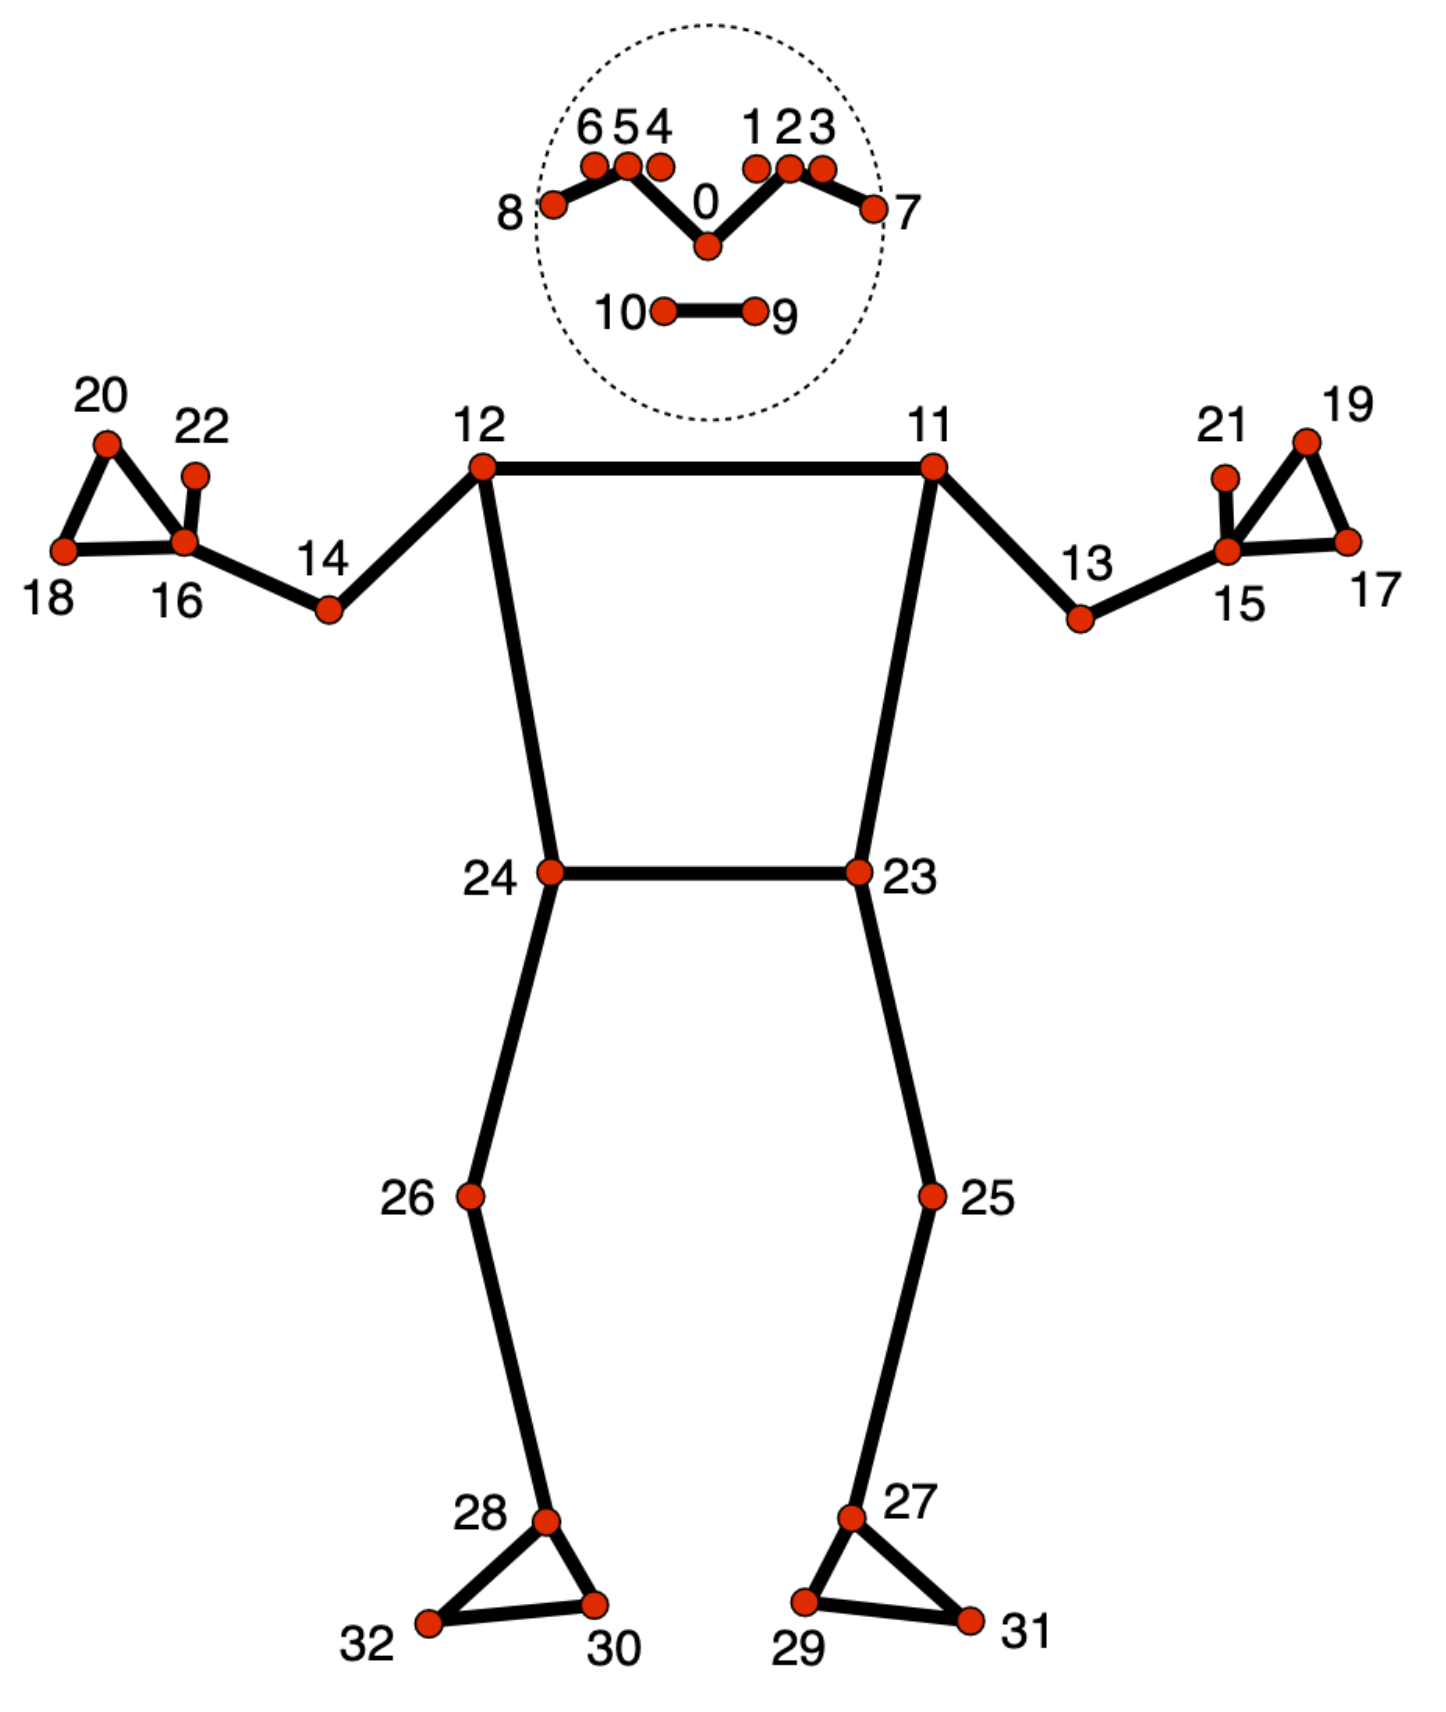
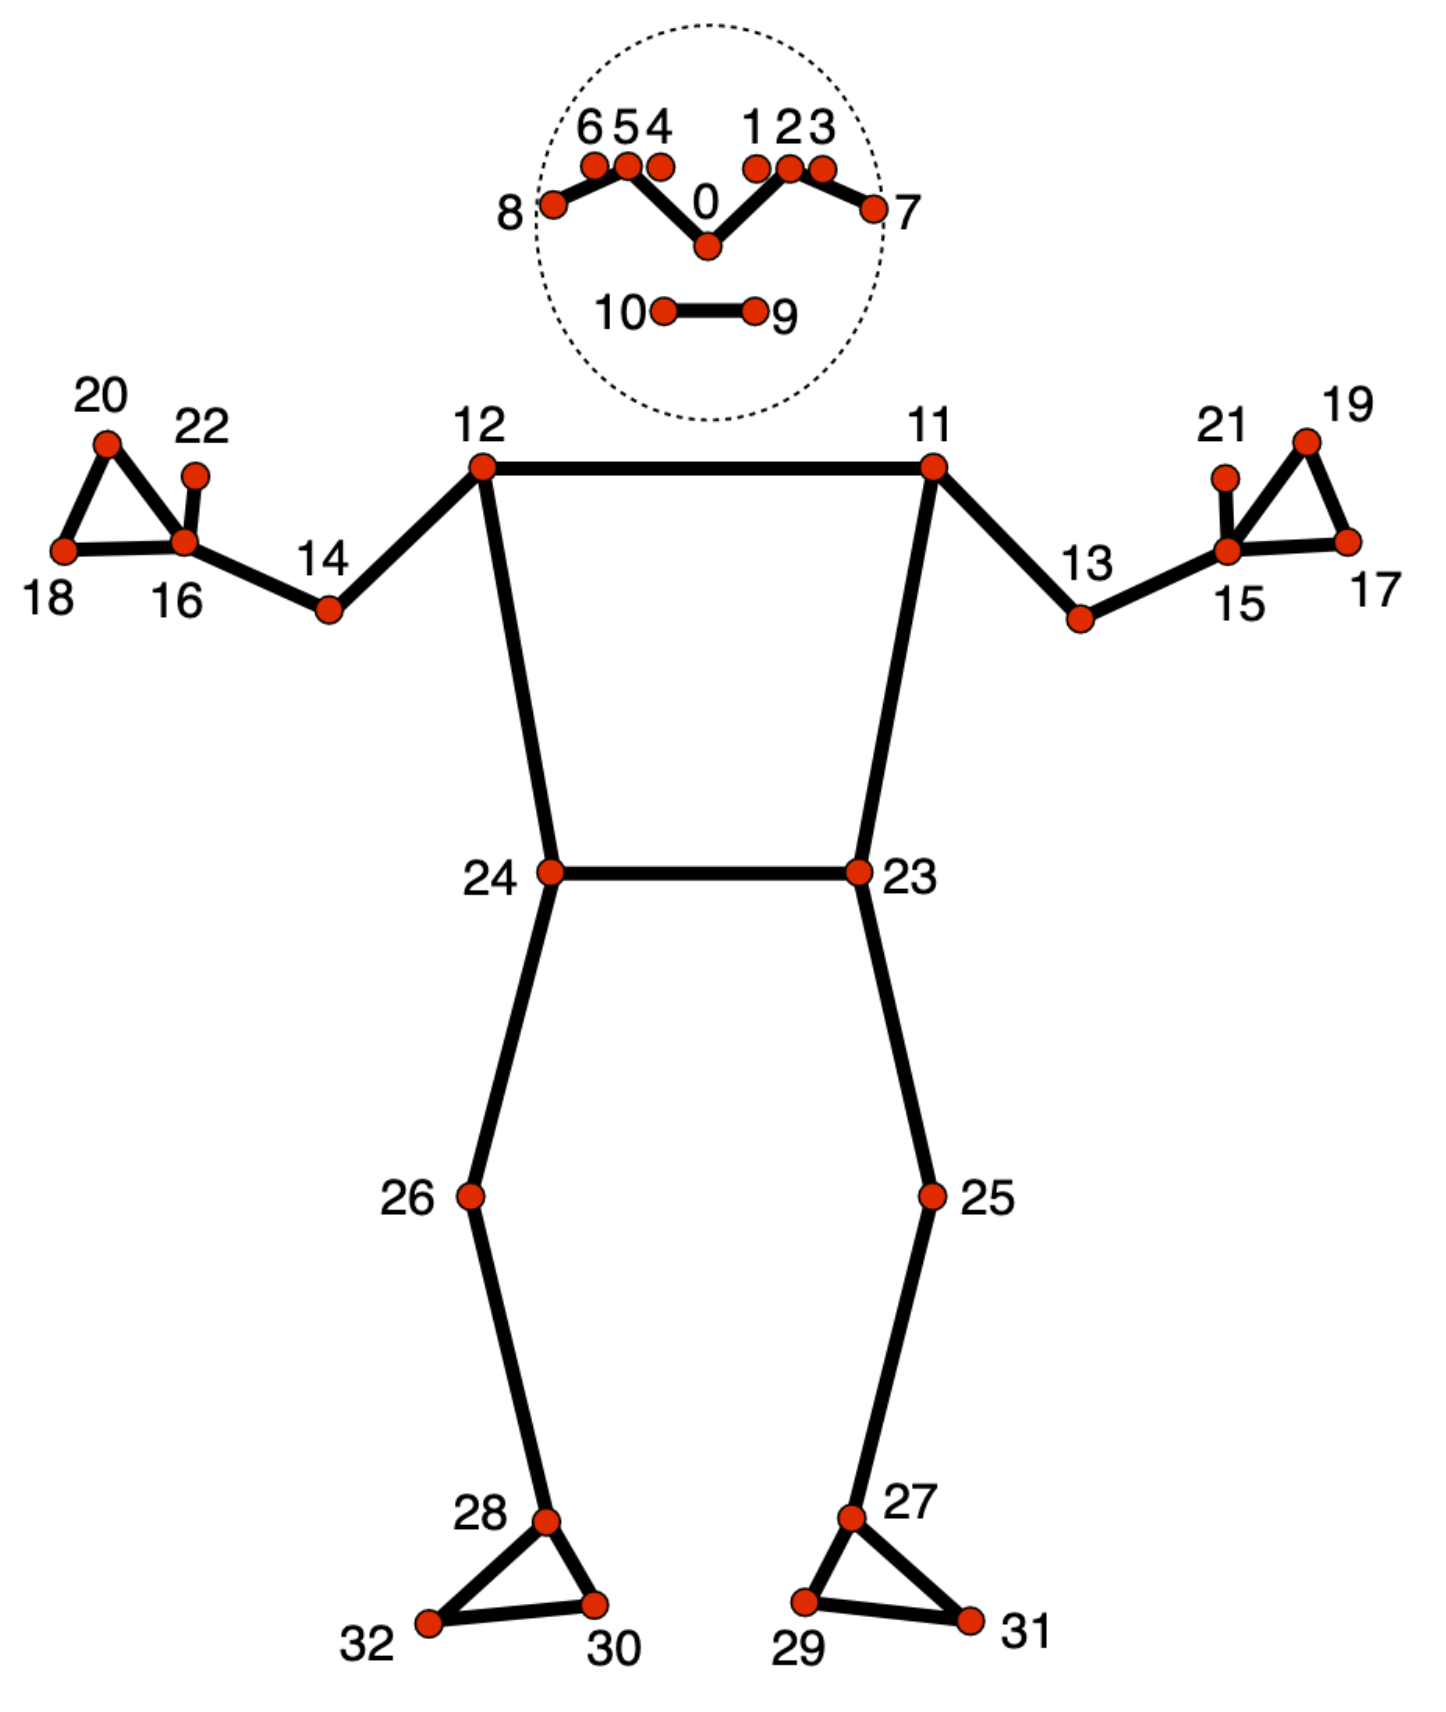

In [13]:
# Coordenadas para las poses de las manos
LPOSE = [13, 15, 17, 19, 21]
RPOSE = [14, 16, 18, 20, 22]
POSE = LPOSE + RPOSE
print(POSE)

[13, 15, 17, 19, 21, 14, 16, 18, 20, 22]


In [14]:
X = [f'x_right_hand_{i}' for i in range(21)] + [f'x_left_hand_{i}' for i in range(21)] + [f'x_pose_{i}' for i in POSE]
Y = [f'y_right_hand_{i}' for i in range(21)] + [f'y_left_hand_{i}' for i in range(21)] + [f'y_pose_{i}' for i in POSE]
Z = [f'z_right_hand_{i}' for i in range(21)] + [f'z_left_hand_{i}' for i in range(21)] + [f'z_pose_{i}' for i in POSE]

print(X[:5])

['x_right_hand_0', 'x_right_hand_1', 'x_right_hand_2', 'x_right_hand_3', 'x_right_hand_4']


In [15]:
FEATURE_COLUMNS = X + Y + Z
print(FEATURE_COLUMNS[:5])

['x_right_hand_0', 'x_right_hand_1', 'x_right_hand_2', 'x_right_hand_3', 'x_right_hand_4']


In [16]:
X_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "x_" in col]
Y_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "y_" in col]
Z_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "z_" in col]

RHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if "right" in col]
LHAND_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "left" in col]
RPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in RPOSE]
LPOSE_IDX = [i for i, col in enumerate(FEATURE_COLUMNS)  if  "pose" in col and int(col[-2:]) in LPOSE]
print(LPOSE_IDX[0])

# Set length of frames to 128
FRAME_LEN = 128

# Create directory to store the new data
if not os.path.isdir("preprocessed"):
    os.mkdir("preprocessed")
else:
    shutil.rmtree("preprocessed")
    os.mkdir("preprocessed")


42


In [17]:

# Loop through each file_id
for file_id in tqdm(dataset_df.file_id.unique()):
    # Parquet file name
    pq_file = f"/kaggle/input/asl-fingerspelling/train_landmarks/{file_id}.parquet"
    # Filter train.csv and fetch entries only for the relevant file_id
    file_df = dataset_df.loc[dataset_df["file_id"] == file_id]
    # Fetch the parquet file
    parquet_df = pq.read_table(f"/kaggle/input/asl-fingerspelling/train_landmarks/{str(file_id)}.parquet",
                              columns=['sequence_id'] + FEATURE_COLUMNS).to_pandas()
    # File name for the updated data
    tf_file = f"preprocessed/{file_id}.tfrecord"
    parquet_numpy = parquet_df.to_numpy()
    # Initialize the pointer to write the output of 
    # each `for loop` below as a sequence into the file.
    with tf.io.TFRecordWriter(tf_file) as file_writer:
        # Loop through each sequence in file.
        for seq_id, phrase in zip(file_df.sequence_id, file_df.phrase):
            # Fetch sequence data
            frames = parquet_numpy[parquet_df.index == seq_id]
            
            # Calculate the number of NaN values in each hand landmark
            r_nonan = np.sum(np.sum(np.isnan(frames[:, RHAND_IDX]), axis = 1) == 0)
            l_nonan = np.sum(np.sum(np.isnan(frames[:, LHAND_IDX]), axis = 1) == 0)
            no_nan = max(r_nonan, l_nonan)
            
            if 2*len(phrase)<no_nan:
                features = {FEATURE_COLUMNS[i]: tf.train.Feature(
                    float_list=tf.train.FloatList(value=frames[:, i])) for i in range(len(FEATURE_COLUMNS))}
                features["phrase"] = tf.train.Feature(bytes_list=tf.train.BytesList(value=[bytes(phrase, 'utf-8')]))
                record_bytes = tf.train.Example(features=tf.train.Features(feature=features)).SerializeToString()
                file_writer.write(record_bytes)

  0%|          | 0/68 [00:00<?, ?it/s]

Se guardaron los tf_records para recuperar cada sesión

In [18]:
tf_records = dataset_df.file_id.map(lambda x: f'/kaggle/working/preprocessed/{x}.tfrecord').unique()
print(f"List of {len(tf_records)} TFRecord files.")

List of 68 TFRecord files.


In [19]:
with open ("/kaggle/input/asl-fingerspelling/character_to_prediction_index.json", "r") as f:
    char_to_num = json.load(f)

print(char_to_num)

{' ': 0, '!': 1, '#': 2, '$': 3, '%': 4, '&': 5, "'": 6, '(': 7, ')': 8, '*': 9, '+': 10, ',': 11, '-': 12, '.': 13, '/': 14, '0': 15, '1': 16, '2': 17, '3': 18, '4': 19, '5': 20, '6': 21, '7': 22, '8': 23, '9': 24, ':': 25, ';': 26, '=': 27, '?': 28, '@': 29, '[': 30, '_': 31, 'a': 32, 'b': 33, 'c': 34, 'd': 35, 'e': 36, 'f': 37, 'g': 38, 'h': 39, 'i': 40, 'j': 41, 'k': 42, 'l': 43, 'm': 44, 'n': 45, 'o': 46, 'p': 47, 'q': 48, 'r': 49, 's': 50, 't': 51, 'u': 52, 'v': 53, 'w': 54, 'x': 55, 'y': 56, 'z': 57, '~': 58}


In [20]:
pad_token = 'P'
start_token = '<'
end_token = '>'

pad_token_idx = 59
start_token_idx = 60
end_token_idx = 61

char_to_num[pad_token] = pad_token_idx
char_to_num[start_token] = start_token_idx
char_to_num[end_token] = end_token_idx

num_to_char = {j: i for i, j in char_to_num.items()}

print(num_to_char)

{0: ' ', 1: '!', 2: '#', 3: '$', 4: '%', 5: '&', 6: "'", 7: '(', 8: ')', 9: '*', 10: '+', 11: ',', 12: '-', 13: '.', 14: '/', 15: '0', 16: '1', 17: '2', 18: '3', 19: '4', 20: '5', 21: '6', 22: '7', 23: '8', 24: '9', 25: ':', 26: ';', 27: '=', 28: '?', 29: '@', 30: '[', 31: '_', 32: 'a', 33: 'b', 34: 'c', 35: 'd', 36: 'e', 37: 'f', 38: 'g', 39: 'h', 40: 'i', 41: 'j', 42: 'k', 43: 'l', 44: 'm', 45: 'n', 46: 'o', 47: 'p', 48: 'q', 49: 'r', 50: 's', 51: 't', 52: 'u', 53: 'v', 54: 'w', 55: 'x', 56: 'y', 57: 'z', 58: '~', 59: 'P', 60: '<', 61: '>'}


In [21]:
def ajustar_rellenar(x):
    if tf.shape(x)[0] < FRAME_LEN:
         x = tf.pad(x, ([[0, FRAME_LEN-tf.shape(x)[0]], [0, 0], [0, 0]]))
    else:
        x = tf.image.resize(x, (FRAME_LEN, tf.shape(x)[1]))
    return x


# Detect the dominant hand from the number of NaN values.
# Dominant hand will have less NaN values since it is in frame moving.
def pre_process(x):
    rhand = tf.gather(x, RHAND_IDX, axis=1)
    lhand = tf.gather(x, LHAND_IDX, axis=1)
    rpose = tf.gather(x, RPOSE_IDX, axis=1)
    lpose = tf.gather(x, LPOSE_IDX, axis=1)
    
    rnan_idx = tf.reduce_any(tf.math.is_nan(rhand), axis=1)
    lnan_idx = tf.reduce_any(tf.math.is_nan(lhand), axis=1)
    
    rnans = tf.math.count_nonzero(rnan_idx)
    lnans = tf.math.count_nonzero(lnan_idx)   
    
  # For dominant hand
    if rnans > lnans:
        hand = lhand
        pose = lpose
        
        hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
        hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
        hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
        hand = tf.concat([1-hand_x, hand_y, hand_z], axis=1)
        
        pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
        pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
        pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
        pose = tf.concat([1-pose_x, pose_y, pose_z], axis=1)
    else:
        hand = rhand
        pose = rpose


    hand_x = hand[:, 0*(len(LHAND_IDX)//3) : 1*(len(LHAND_IDX)//3)]
    hand_y = hand[:, 1*(len(LHAND_IDX)//3) : 2*(len(LHAND_IDX)//3)]
    hand_z = hand[:, 2*(len(LHAND_IDX)//3) : 3*(len(LHAND_IDX)//3)]
    hand = tf.concat([hand_x[..., tf.newaxis], hand_y[..., tf.newaxis], hand_z[..., tf.newaxis]], axis=-1)
    
    mean = tf.math.reduce_mean(hand, axis=1)[:, tf.newaxis, :]
    std = tf.math.reduce_std(hand, axis=1)[:, tf.newaxis, :]
    hand = (hand - mean) / std

    pose_x = pose[:, 0*(len(LPOSE_IDX)//3) : 1*(len(LPOSE_IDX)//3)]
    pose_y = pose[:, 1*(len(LPOSE_IDX)//3) : 2*(len(LPOSE_IDX)//3)]
    pose_z = pose[:, 2*(len(LPOSE_IDX)//3) : 3*(len(LPOSE_IDX)//3)]
    pose = tf.concat([pose_x[..., tf.newaxis], pose_y[..., tf.newaxis], pose_z[..., tf.newaxis]], axis=-1)
    
    x = tf.concat([hand, pose], axis=1)
    x = ajustar_rellenar(x)
    
    x = tf.where(tf.math.is_nan(x), tf.zeros_like(x), x)
    x = tf.reshape(x, (FRAME_LEN, len(LHAND_IDX) + len(LPOSE_IDX)))
    return x

print(pre_process)

<function pre_process at 0x78ed289a9440>


In [22]:
def decode_fn(record_bytes):
    schema = {COL: tf.io.VarLenFeature(dtype=tf.float32) for COL in FEATURE_COLUMNS}
    schema["phrase"] = tf.io.FixedLenFeature([], dtype=tf.string)
    features = tf.io.parse_single_example(record_bytes, schema)
    phrase = features["phrase"]
    landmarks = ([tf.sparse.to_dense(features[COL]) for COL in FEATURE_COLUMNS])
    # Transpose to maintain the original shape of landmarks data.
    landmarks = tf.transpose(landmarks)
    
    return landmarks, phrase

print(decode_fn)

<function decode_fn at 0x78ece7b399e0>


In [23]:
table = tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=list(char_to_num.keys()),
        values=list(char_to_num.values()),
    ),
    default_value=tf.constant(-1),
    name="class_weight"
)

def convert_fn(landmarks, phrase):
    # Add start and end pointers to phrase.
    phrase = start_token + phrase + end_token
    phrase = tf.strings.bytes_split(phrase)
    phrase = table.lookup(phrase)
    # Vectorize and add padding.
    phrase = tf.pad(phrase, paddings=[[0, 64 - tf.shape(phrase)[0]]], mode = 'CONSTANT',
                    constant_values = pad_token_idx)
    # Apply pre_process function to the landmarks.
    return pre_process(landmarks), phrase

print(convert_fn)

<function convert_fn at 0x78ed361b6200>


I0000 00:00:1761158739.820251     278 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761158739.820884     278 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [24]:
batch_size = 64
train_len = int(0.8 * len(tf_records))

train_ds = tf.data.TFRecordDataset(tf_records[:train_len]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()
valid_ds = tf.data.TFRecordDataset(tf_records[train_len:]).map(decode_fn).map(convert_fn).batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE).cache()

train_ds

<CacheDataset element_spec=(TensorSpec(shape=(None, 128, 78), dtype=tf.float32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>

# TRANSFORMER

In [67]:
class TokenEmbedding(layers.Layer):
    def __init__(self, num_vocab=1000, maxlen=100, num_hid=64):
        super().__init__()
        self.emb = tf.keras.layers.Embedding(num_vocab, num_hid)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        x = self.emb(x)
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        return x + positions


class LandmarkEmbedding(layers.Layer):
    def __init__(self, num_hid=64, maxlen=100):
        super().__init__()
        self.conv1 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv2 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.conv3 = tf.keras.layers.Conv1D(
            num_hid, 11, strides=2, padding="same", activation="relu"
        )
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=num_hid)

    def call(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        return self.conv3(x)

def dense_to_sparse_without_ids(dense_ids, remove_ids):
    """
    Convierte [B, T] a SparseTensor filtrando los IDs en remove_ids (ej. PAD, START, END).
    """
    dense_ids = tf.convert_to_tensor(dense_ids)
    mask = tf.ones_like(dense_ids, dtype=tf.bool)
    for rid in remove_ids:
        if rid is not None:
            mask = tf.logical_and(mask, tf.not_equal(dense_ids, rid))
    indices = tf.where(mask)
    values = tf.gather_nd(dense_ids, indices)
    dense_shape = tf.cast(tf.shape(dense_ids), tf.int64)
    return tf.SparseTensor(indices=tf.cast(indices, tf.int64),
                           values=tf.cast(values, tf.int32),
                           dense_shape=dense_shape)

def cer_from_dense(pred_tokens, true_tokens, remove_ids):
    """
    CER promedio (edit distance normalizada) filtrando IDs en remove_ids.
    """
    with tf.device('/CPU:0'):
        pred_sp = dense_to_sparse_without_ids(pred_tokens, remove_ids)
        true_sp = dense_to_sparse_without_ids(true_tokens, remove_ids)
        dist = tf.edit_distance(pred_sp, true_sp, normalize=True)
        return tf.reduce_mean(dist)


print(LandmarkEmbedding)

<class '__main__.LandmarkEmbedding'>


In [59]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, rate=0.1):
        super().__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

print(TransformerEncoder)

<class '__main__.TransformerEncoder'>


In [60]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, feed_forward_dim, dropout_rate=0.1):
        super().__init__()
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = layers.LayerNormalization(epsilon=1e-6)
        self.self_att = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.enc_att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.self_dropout = layers.Dropout(0.5)
        self.enc_dropout = layers.Dropout(0.1)
        self.ffn_dropout = layers.Dropout(0.1)
        self.ffn = keras.Sequential(
            [
                layers.Dense(feed_forward_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )

    def causal_attention_mask(self, batch_size, n_dest, n_src, dtype):
        """Masks the upper half of the dot product matrix in self attention.

        This prevents flow of information from future tokens to current token.
        1's in the lower triangle, counting from the lower right corner.
        """
        i = tf.range(n_dest)[:, None]
        j = tf.range(n_src)
        m = i >= j - n_src + n_dest
        mask = tf.cast(m, dtype)
        mask = tf.reshape(mask, [1, n_dest, n_src])
        mult = tf.concat(
            [batch_size[..., tf.newaxis], tf.constant([1, 1], dtype=tf.int32)], 0
        )
        return tf.tile(mask, mult)

    def call(self, inputs, training= None):
        # Espera inputs = [enc_out, target]
        enc_out, target = inputs
        
        input_shape = tf.shape(target)
        batch_size = input_shape[0]
        seq_len = input_shape[1]
        causal_mask = self.causal_attention_mask(batch_size, seq_len, seq_len, tf.bool)
        target_att = self.self_att(target, target, attention_mask=causal_mask)
        target_norm = self.layernorm1(target + self.self_dropout(target_att, training = training))
        enc_out = self.enc_att(target_norm, enc_out)
        enc_out_norm = self.layernorm2(self.enc_dropout(enc_out, training = training) + target_norm)
        ffn_out = self.ffn(enc_out_norm)
        ffn_out_norm = self.layernorm3(enc_out_norm + self.ffn_dropout(ffn_out, training = training))
        return ffn_out_norm

print(TransformerDecoder)

<class '__main__.TransformerDecoder'>


In [70]:

class Transformer(keras.Model):
    def __init__(
        self,
        num_hid=64,
        num_head=2,
        num_feed_forward=128,
        source_maxlen=100,
        target_maxlen=100,
        num_layers_enc=4,
        num_layers_dec=1,
        num_classes=60,
    ):
        super().__init__()
        self.loss_metric = keras.metrics.Mean(name="loss")
        self.acc_metric = keras.metrics.Mean(name="edit_dist")
        self.num_layers_enc = num_layers_enc
        self.num_layers_dec = num_layers_dec
        self.target_maxlen = target_maxlen
        self.num_classes = num_classes

        self.enc_input = LandmarkEmbedding(num_hid=num_hid, maxlen=source_maxlen)
        self.dec_input = TokenEmbedding(
            num_vocab=num_classes, maxlen=target_maxlen, num_hid=num_hid
        )

        self.encoder = keras.Sequential(
            [self.enc_input]
            + [
                TransformerEncoder(num_hid, num_head, num_feed_forward)
                for _ in range(num_layers_enc)
            ]
        )
        
        for i in range(num_layers_dec):
            setattr(
                self,
                f"dec_layer_{i}",
                TransformerDecoder(num_hid, num_head, num_feed_forward),
            )

        self.classifier = layers.Dense(num_classes)

    def decode(self, enc_out, target, training=None):
        y = self.dec_input(target)
        for i in range(self.num_layers_dec):
            y = getattr(self, f"dec_layer_{i}")([enc_out, y], training=training)
        return y

    def call(self, inputs, training=None):
        source = inputs[0]
        target = inputs[1]
        x = self.encoder(source, training=training)
        y = self.decode(x, target, training=training)
        return self.classifier(y)


    @property
    def metrics(self):
        return [self.loss_metric]

    def train_step(self, batch):
        source, target = batch
        dec_input  = target[:, :-1]
        dec_target = target[:, 1:]
    
        with tf.GradientTape() as tape:
            preds = self([source, dec_input], training=True)
            one_hot = tf.one_hot(dec_target, depth=self.num_classes)
            mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
            loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
    
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))
    
        # ===== métrica CER correcta =====
        pred_tokens  = tf.cast(tf.argmax(preds, axis=-1), tf.int32)  # [B, T-1]
        truth_tokens = dec_target                                    # [B, T-1]
        
        remove_ids = [pad_token_idx, char_to_num.get('<'), char_to_num.get('>')]
        cer = cer_from_dense(pred_tokens, truth_tokens, remove_ids) 
        # =================================
    
        self.acc_metric.update_state(cer)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}
    
    
    def test_step(self, batch):
        source, target = batch
        dec_input  = target[:, :-1]
        dec_target = target[:, 1:]
    
        preds = self([source, dec_input], training=False)
        one_hot = tf.one_hot(dec_target, depth=self.num_classes)
        mask = tf.math.logical_not(tf.math.equal(dec_target, pad_token_idx))
        loss = self.compiled_loss(one_hot, preds, sample_weight=mask)
    
        # ===== métrica CER correcta =====
        pred_tokens  = tf.cast(tf.argmax(preds, axis=-1), tf.int32)  # [B, T-1]
        truth_tokens = dec_target                                    # [B, T-1]
        
        remove_ids = [pad_token_idx, char_to_num.get('<'), char_to_num.get('>')]
        cer = cer_from_dense(pred_tokens, truth_tokens, remove_ids) 
        # =================================
    
        self.acc_metric.update_state(cer)
        self.loss_metric.update_state(loss)
        return {"loss": self.loss_metric.result(), "edit_dist": self.acc_metric.result()}

    def generate(self, source, target_start_token_idx):
        """Performs inference over one batch of inputs using greedy decoding."""
        bs = tf.shape(source)[0]
        enc = self.encoder(source, training = False)
        dec_input = tf.ones((bs, 1), dtype=tf.int32) * target_start_token_idx
        dec_logits = []
        for i in range(self.target_maxlen - 1):
            dec_out = self.decode(enc, dec_input, training = False)
            logits = self.classifier(dec_out)
            logits = tf.argmax(logits, axis=-1, output_type=tf.int32)
            last_logit = logits[:, -1][..., tf.newaxis]
            dec_logits.append(last_logit)
            dec_input = tf.concat([dec_input, last_logit], axis=-1)
        return dec_input

print(Transformer)

<class '__main__.Transformer'>


In [63]:
class DisplayOutputs(keras.callbacks.Callback):
    def __init__(
        self, batch, idx_to_token,
        target_start_token_idx=60, target_end_token_idx=61,
        pad_idx=None, show_every=4
    ):
        self.batch = batch
        self.target_start_token_idx = target_start_token_idx
        self.target_end_token_idx = target_end_token_idx
        self.idx_to_char = idx_to_token
        self.pad_idx = pad_idx
        self.show_every = show_every

    def on_epoch_end(self, epoch, logs=None):
        if self.show_every and (epoch % self.show_every != 0):
            return

        source = self.batch[0]
        target = self.batch[1].numpy()
        bs = tf.shape(source)[0]

        preds = self.model.generate(source, self.target_start_token_idx).numpy()

        # --- CER del batch mostrado (filtrando PAD/< /> si se pasan) ---
        remove_ids = [self.pad_idx, self.target_start_token_idx, self.target_end_token_idx]
        cer_val = float(cer_from_dense(preds, target, remove_ids).numpy()) if self.pad_idx is not None else float('nan')
        print(f"\n[DISPLAY BATCH] Epoch {epoch+1}: CER(batch) = {cer_val:.4f}\n")

        # --- Ejemplos legibles ---
        for i in range(int(bs)):
            target_text = "".join([self.idx_to_char[_] for _ in target[i, :]])
            prediction = ""
            for idx in preds[i, :]:
                prediction += self.idx_to_char[idx]
                if idx == self.target_end_token_idx:
                    break
            print(f"target:     {target_text.replace('-','')}")
            print(f"prediction: {prediction}\n")


print(DisplayOutputs)

<class '__main__.DisplayOutputs'>


In [71]:
# Transformer variables are customized from original keras tutorial to suit this dataset.
# Reference: https://www.kaggle.com/code/shlomoron/aslfr-a-simple-transformer/notebook

batch = next(iter(valid_ds))

# The vocabulary to convert predicted indices into characters
idx_to_char = list(char_to_num.keys())
display_cb = DisplayOutputs(
    batch,
    idx_to_token=idx_to_char,
    target_start_token_idx=char_to_num['<'],
    target_end_token_idx=char_to_num['>'],
    pad_idx=pad_token_idx,
    show_every=4
)

model = Transformer(
    num_hid=200,
    num_head=4,
    num_feed_forward=400,
    source_maxlen = FRAME_LEN,
    target_maxlen=64,
    num_layers_enc=2,
    num_layers_dec=1,
    num_classes=62
)
loss_fn = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, label_smoothing=0.1,
)

tf.config.optimizer.set_jit(False)

optimizer = keras.optimizers.Adam(0.0001)
model.compile(optimizer=optimizer, loss=loss_fn,jit_compile=False)

history = model.fit(train_ds, validation_data=valid_ds, callbacks=[display_cb], epochs=13)

Epoch 1/13


/usr/local/lib/python3.11/dist-packages/keras/src/layers/layer.py:393: UserWarning: `build()` was called on layer 'landmark_embedding_8', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


    631/Unknown 47s 55ms/step - edit_dist: 2.9506 - loss: 0.9695
[DISPLAY BATCH] Epoch 1: CER(batch) = 1.5095

target:     <2796 west golden willow drive>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <785 soute st rorerourourt>

target:     <9734719887>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <http:///www.comarom>

target:     <4977236992>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <989-161-1626>

target:     <reallyloud.co.uk/simaii>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <delesorerones>

target:     <kkaicd1.pixnet.net>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <https://walangangestanalas>

target:     <8260 john r bowdoin>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <886 win rore rore>

target:     <56 paper birch drive>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <401-201-7071>

target:     <gandchudaihardcor.html>PPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPPP
prediction: <http:///ww.charerom/>

target:

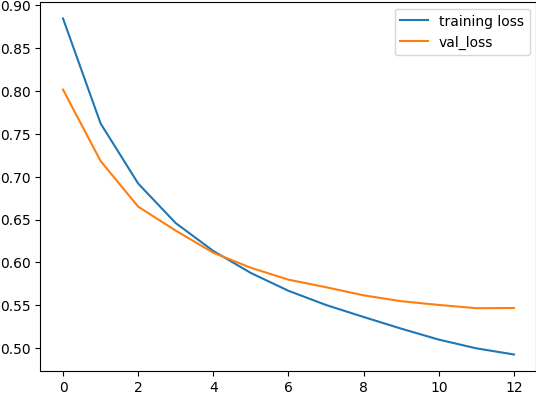

In [72]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training loss', 'val_loss'])

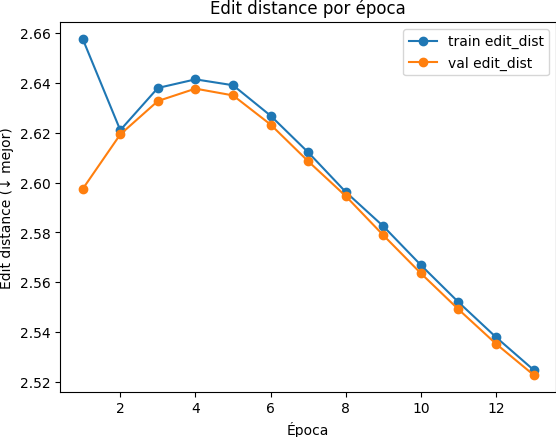

In [78]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(1, len(history.history['edit_dist'])+1)
plt.plot(x, history.history['edit_dist'], marker='o', label='train edit_dist')
plt.plot(x, history.history['val_edit_dist'], marker='o', label='val edit_dist')
plt.xlabel('Época'); plt.ylabel('Edit distance (↓ mejor)')
plt.title('Edit distance por época')
plt.legend()


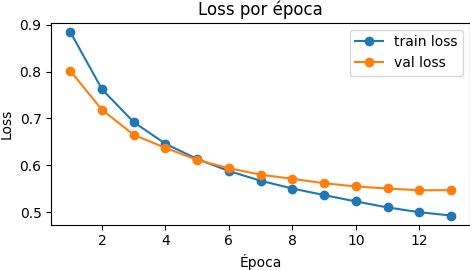

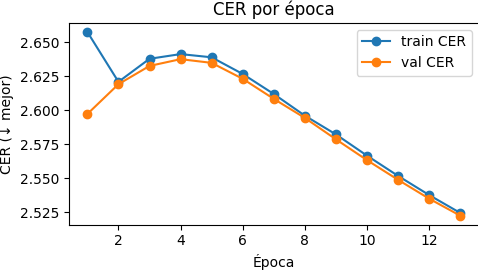

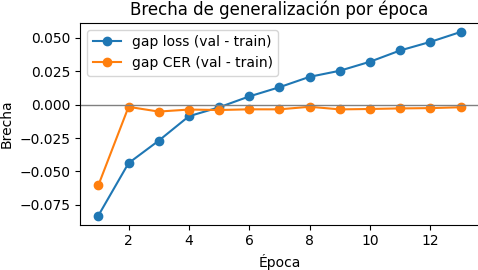

In [83]:
import numpy as np
import matplotlib.pyplot as plt

ep = np.arange(1, len(history.history['loss'])+1)

# 1) Loss
plt.figure(figsize=(5,3))
plt.plot(ep, history.history['loss'], marker='o', label='train loss')
plt.plot(ep, history.history['val_loss'], marker='o', label='val loss')
plt.xlabel('Época'); plt.ylabel('Loss'); plt.title('Loss por época')
plt.legend(); plt.tight_layout(); plt.show()

# 2) CER (edit distance normalizada)
plt.figure(figsize=(5,3))
plt.plot(ep, history.history['edit_dist'], marker='o', label='train CER')
plt.plot(ep, history.history['val_edit_dist'], marker='o', label='val CER')
plt.xlabel('Época'); plt.ylabel('CER (↓ mejor)'); plt.title('CER por época')
plt.legend(); plt.tight_layout(); plt.show()

# 3) Brecha (valid - train) por época
gap_loss = np.array(history.history['val_loss']) - np.array(history.history['loss'])
gap_cer  = np.array(history.history['val_edit_dist']) - np.array(history.history['edit_dist'])

plt.figure(figsize=(5,3))
plt.plot(ep, gap_loss, marker='o', label='gap loss (val - train)')
plt.plot(ep, gap_cer,  marker='o', label='gap CER (val - train)')
plt.axhline(0, color='gray', linewidth=1)
plt.xlabel('Época'); plt.ylabel('Brecha'); plt.title('Brecha de generalización por época')
plt.legend(); plt.tight_layout(); plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

true_chars = []
pred_chars = []
for batch in valid_ds.take(50):
    source, target = batch
    preds = model([source, target[:, :-1]], training=False)
    pred_ids = tf.argmax(preds, axis=-1).numpy()
    for t, p in zip(target.numpy().ravel(), pred_ids.ravel()):
        if t not in [pad_token_idx, start_token_idx, end_token_idx]:
            true_chars.append(t)
            pred_chars.append(p)

cm = confusion_matrix(true_chars, pred_chars)
sns.heatmap(cm, cmap='Blues')
plt.xlabel('Predicho')
plt.ylabel('Verdadero')
plt.title('Matriz de confusión de caracteres')
plt.show()


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# ========= Helpers =========
def dense_to_sparse_without_ids(dense_ids, remove_ids):
    dense_ids = tf.convert_to_tensor(dense_ids)
    mask = tf.ones_like(dense_ids, dtype=tf.bool)
    for rid in remove_ids:
        if rid is not None:
            mask = tf.logical_and(mask, tf.not_equal(dense_ids, rid))
    idx = tf.where(mask)
    vals = tf.gather_nd(dense_ids, idx)
    shape = tf.cast(tf.shape(dense_ids), tf.int64)
    return tf.SparseTensor(tf.cast(idx, tf.int64), tf.cast(vals, tf.int32), shape)

def seq_lengths_from_sparse(sp):
    # cuenta elementos por muestra: segment_sum(1s) sobre índice de batch
    ones = tf.ones_like(sp.values, dtype=tf.int32)
    return tf.math.segment_sum(ones, sp.indices[:, 0])  # [B]

def cer_tf_normalized(pred_sp, true_sp):
    # CER "oficial" de TF, ya normalizada por la longitud de referencia
    return tf.edit_distance(pred_sp, true_sp, normalize=True)  # [B]

def cer_manual_from_raw(raw_dist, true_len):
    # CER manual = distancia cruda / longitud de referencia (evitar div. por 0)
    true_len = tf.cast(true_len, tf.float32)
    raw_dist = tf.cast(raw_dist, tf.float32)
    safe_len = tf.maximum(true_len, 1.0)
    return raw_dist / safe_len

def compute_batch_cer(source, target, start_idx, remove_ids, model):
    """Devuelve CER normalizado por muestra (dos vías) + diagnósticos."""
    # 1) Predicción greedy
    pred = model.generate(source, start_idx)   # [B, T_dec]
    # 2) Alinear con verdad "shifted": dec_target (target[:, 1:])
    truth = target[:, 1:]

    # 3) Recorte para evitar desalineación de longitudes
    Tm = tf.minimum(tf.shape(pred)[1], tf.shape(truth)[1])
    pred = pred[:, :Tm]
    truth = truth[:, :Tm]

    # 4) Sparse + longitudes
    pred_sp  = dense_to_sparse_without_ids(pred,  remove_ids)
    true_sp  = dense_to_sparse_without_ids(truth, remove_ids)
    true_len = seq_lengths_from_sparse(true_sp)  # [B]

    # 5) CER de TF (normalizado) y crudo
    cer_tf = cer_tf_normalized(pred_sp, true_sp)          # [B], esperado en [0,1] si todo OK
    raw    = tf.edit_distance(pred_sp, true_sp, normalize=False)  # [B]
    cer_m  = cer_manual_from_raw(raw, true_len)           # [B], nuestra verificación

    return cer_tf, cer_m, true_len, pred_sp, true_sp

# ========= Runner =========
def verify_cer_on_valid(model, valid_ds, pad_token_idx, start_idx, end_idx=None, 
                        max_batches=30, plot_hist=True):
    remove_ids = [pad_token_idx, start_idx, end_idx]
    all_tf, all_manual, all_tlen = [], [], []
    any_pred_len, any_true_len = [], []

    for b, (source, target) in enumerate(valid_ds):
        if b >= max_batches: break
        cer_tf, cer_m, tlen, pred_sp, true_sp = compute_batch_cer(
            source, target, start_idx, remove_ids, model
        )
        all_tf.append(cer_tf.numpy())
        all_manual.append(cer_m.numpy())
        all_tlen.append(tlen.numpy())

        # diagnósticos de longitudes (promedio por batch)
        pred_len = seq_lengths_from_sparse(pred_sp)
        any_pred_len.append(np.mean(pred_len.numpy()) if pred_len.shape[0] > 0 else 0.0)
        any_true_len.append(np.mean(tlen.numpy())        if tlen.shape[0] > 0 else 0.0)

    if not all_tf:
        print("No se pudo evaluar (¿valid_ds vacío?).")
        return

    cer_tf_all = np.concatenate(all_tf)       # CER TF normalizado
    cer_m_all  = np.concatenate(all_manual)   # CER manual (raw/len)
    tlen_all   = np.concatenate(all_tlen)

    # === Resumen numérico ===
    def stats(x):
        return np.mean(x), np.median(x), np.min(x), np.max(x)

    m_tf, med_tf, mi_tf, ma_tf = stats(cer_tf_all)
    m_mn, med_mn, mi_mn, ma_mn = stats(cer_m_all)

    print("=== CER (TF normalizado) ===")
    print(f"mean={m_tf:.4f}, median={med_tf:.4f}, min={mi_tf:.4f}, max={ma_tf:.4f}")
    print("=== CER (manual: raw / true_len) ===")
    print(f"mean={m_mn:.4f}, median={med_mn:.4f}, min={mi_mn:.4f}, max={ma_mn:.4f}")

    # chequeo: ambas deben ser ~iguales y estar en [0,1]
    diff = np.abs(cer_tf_all - cer_m_all)
    print(f"Δ(CER_TF - CER_manual): mean={diff.mean():.6f}, max={diff.max():.6f}")

    # alerta si algo está fuera de rango
    if ma_tf > 1.0 + 1e-6 or ma_mn > 1.0 + 1e-6:
        print("⚠️  CER > 1 detectado. Revisa alineación y filtrado de IDs (PAD/START/END).")

    # diagnóstico de longitudes promedio por batch
    print(f"Longitud promedio predicha (por batch): {np.mean(any_pred_len):.2f}")
    print(f"Longitud promedio verdadera (por batch): {np.mean(any_true_len):.2f}")

    # === Gráficos opcionales ===
    if plot_hist:
        epochs_axis = np.arange(1, len(cer_tf_all)+1)  # no son épocas, pero nos sirve como índice de muestras

        plt.figure(figsize=(12,4))
        plt.subplot(1,3,1)
        plt.hist(cer_tf_all, bins=20)
        plt.title("Hist. CER TF (normalizado)")
        plt.xlabel("CER"); plt.ylabel("freq")

        plt.subplot(1,3,2)
        plt.scatter(tlen_all, cer_tf_all, s=8, alpha=0.5)
        plt.title("CER vs longitud (verdad)")
        plt.xlabel("len(verdad)"); plt.ylabel("CER")

        plt.subplot(1,3,3)
        plt.hist(diff, bins=20)
        plt.title("Δ CER_TF - CER_manual")
        plt.xlabel("abs diff"); plt.ylabel("freq")

        plt.tight_layout()
        plt.show()

# ========= Ejecuta la verificación =========
verify_cer_on_valid(
    model=model,
    valid_ds=valid_ds,
    pad_token_idx=pad_token_idx,
    start_idx=char_to_num['<'],
    end_idx=char_to_num.get('>'),
    max_batches=30,     # sube/baja para rapidez
    plot_hist=True
)
